In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
# path to the saved model
path = "/gdrive/My Drive/models3/checkpoint-5-3000.ckpt"
embed_size = 256
in_size = 224
hidden_size = 512
num_layers = 1
max_seq_length = 20

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from pycocotools.coco import COCO # coco api
from collections import Counter # to count occurences of tokens
import nltk #for tokenization
import os 
from PIL import Image
nltk.download('punkt') #needed for nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
checkpoint = torch.load(path)

In [0]:
# the commented lines should be uncomented when using a checkpoint that has validation data.
train_losses = checkpoint['train_losses']
max_train_loss = max(train_losses)
#val_losses = checkpoint['val_losses']
#max_val_loss = max(val_losses)
train_losses_normalized = np.array(train_losses)/max_train_loss
#val_losses_normalized = np.array(val_losses)/max_val_loss
x = range(len(train_losses))

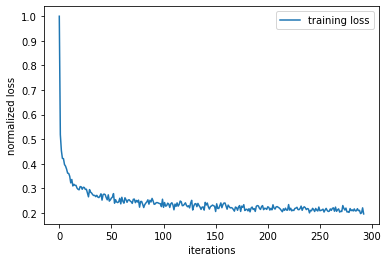

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x,train_losses_normalized,label="training loss")
#plt.plot(x,val_losses_normalized,label="validation loss")
plt.xlabel("iterations")
plt.ylabel("normalized loss")
plt.legend()


In [0]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        #call the constrctor of mother-class
        super(Encoder, self).__init__()
        
        #load pretrained resnet(110 layers)
        self.resnet101 = models.resnet101(pretrained=False)
        last_layer_nodes = self.resnet101.fc.in_features
        self.resnet101 = nn.Sequential(*(list(self.resnet101.children())[:-1]))
        
        #freeze weights
        for parameter in self.resnet101.parameters():
            parameter.requires_grad = False
            
        #replace last fully connected layer(trainable layer)
        self.fc = nn.Linear(last_layer_nodes, embed_size)
        
        #add a batch normalization layer after each batch
        self.batch_norm = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, batch):
        #
        features = self.resnet101(batch)
        features = features.reshape(features.size(0), -1)
        features = self.batch_norm(self.fc(features))
        return features

In [0]:

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length):
        #call the super class's constructor
        super(Decoder, self).__init__()

        #create the embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        #create the LSTM cell
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        #create the linear outer layer
        self.linear = nn.Linear(hidden_size, vocab_size)

        #maximum sequence length
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    def predict(self, features, states=None):
        predictedids = []
        inputs = features.unsqueeze(1)
        #while number of generated words is smaller than max_seg_length
        for i in range(self.max_seg_length):
            #forward the input through the lstm
            hiddens, states = self.lstm(inputs, states)
            #map to the vocabulary size
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            predictedids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        predictedids = torch.stack(predictedids, 1)
        return predictedids

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class Vocabulary():
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word_to_id = {}
        self.id_to_word = {}
        self.id = 0
        self.i = 0

    def append(self, word):
        if not word in self.word_to_id:
            self.word_to_id[word] = self.id
            self.id_to_word[self.id] = word
            self.id += 1

    def __call__(self, word):
        if not word in self.word_to_id:
            return self.word_to_id['<NA>']
        return self.word_to_id[word]

    def __len__(self):
        return self.id+1

In [0]:
import pickle
with open("/gdrive/My Drive/annotations/vocab", 'rb') as f:
  vocab = pickle.load(f)

In [0]:
# Build the models
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers, max_seq_length).to(device)

In [13]:
# load the checkpoint
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])


<All keys matched successfully>

In [0]:
%%capture
encoder.eval()
decoder.eval()

In [0]:
#torch.save(encoder,"/content/encoder.pt")
#torch.save(decoder,"/content/decoder.pt")

In [16]:
cd /content

/content


In [0]:
transform = transforms.Compose([ 
        transforms.Resize((in_size,in_size)),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [0]:
def getCaption(image) :
  # Generate an caption from the image
  features = encoder(image)
  sampled_ids = decoder.sample(features)
  sampled_ids = sampled_ids[0].cpu().numpy()

  # Convert word_ids to words
  sampled_caption = []
  for word_id in sampled_ids:
      word = vocab.id_to_word[word_id]
      sampled_caption.append(word)
      if word == '<end>':
          break
  sentence = ' '.join(sampled_caption[1:-1])
  return sentence


In [0]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip

In [0]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip

In [0]:
import json
data = '/content/annotations/captions_val2017.json'
with open(data,'r') as COCO:
    js = json.loads(COCO.read())
    js = js['images']

# cats as in categories and not real cats :c
name_to_id = {}
for e in js:
    name_to_id[e['file_name']] = e['id']
    
len(name_to_id)

5000

In [0]:
all_captions = []
for name in name_to_id :
  image_path = "val2017/"+name
  image = Image.open(image_path).convert('RGB')
  image = transform(image).unsqueeze(0).to(device)
  caption = getCaption(image)
  entry = {"image_id" : name_to_id[name], "caption" : caption}
  all_captions.append(entry)

In [0]:
fp = open("captions_val2017_local1iter_results.json", 'a')
json.dump(all_captions, fp)
fp.close()